## Описание проекта

**Задача:** Анализ активности студентов онлайн курса [Введение в анализ данных в R](https://stepik.org/course/129/promo#toc).  
**Цель:** Как можно раньше предсказать, что наш пользователь уйдет с курса, не завершив его.

**Описание данных:**

**`events_train.csv`** - данные о действиях, которые совершают студенты со стэпами

* `step_id` - id стэпа
* `user_id` - анонимизированный id юзера
* `timestamp` - время наступления события в формате `unix date`
* `action` - событие, возможные значения: 
    * `discovered` - пользователь перешел на стэп
    * `viewed` - просмотр шага,
    * `started_attempt` - начало попытки решить шаг (ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага)
    * `passed` - удачное решение практического шага  

**`submissions_train.csv`** - данные о времени и статусах сабмитов к практическим заданиям

* `step_id` - `id` стэпа
* `timestamp` - время отправки решения в формате `unix date`
* `submission_status` - статус решения
* `user_id` - анонимизированный `id` пользователя

## Загрузка и обработка данных

In [ ]:
import pandas as pd
import numpy as np

from google.colab import files
import io

import matplotlib.pyplot as plt


In [ ]:
!gdown --id 1f6PcQMuzXhJfhC3A4-jJnhF6-NRj9ewg --quiet 
sub_data = pd.read_csv('submissions_data_train.csv')

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [ ]:
uploaded = files.upload()

event_data = pd.read_csv(io.BytesIO(uploaded['event_data_train.csv']))


Saving event_data_train.csv to event_data_train.csv


In [ ]:
sub_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [ ]:
event_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [ ]:
sub_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509104 entries, 0 to 509103
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   step_id            509104 non-null  int64 
 1   timestamp          509104 non-null  int64 
 2   submission_status  509104 non-null  object
 3   user_id            509104 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 15.5+ MB


In [ ]:
event_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480703 entries, 0 to 3480702
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   step_id    int64 
 1   timestamp  int64 
 2   action     object
 3   user_id    int64 
dtypes: int64(3), object(1)
memory usage: 106.2+ MB


Добавим колонку с преобразованным временем.

In [ ]:
event_data['date'] = pd.to_datetime(event_data.timestamp, unit='s')
sub_data['date'] = pd.to_datetime(sub_data.timestamp, unit='s')

In [ ]:
event_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [ ]:
sub_data.head()

,step_id,timestamp,submission_status,user_id,date
0,31971,1434349275,correct,15853,2015-06-15 06:21:15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49
3,31972,1478852164,correct,15853,2016-11-11 08:16:04
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03


In [ ]:
print(f'Время и дата, когда первый студент зашел на курс: {event_data.date.min()}')

Время и дата, когда первый студент зашел на курс: 2015-06-15 04:00:48


In [ ]:
print(f'Максимальная дата в наших данных: {event_data.date.max()}')

Максимальная дата в наших данных: 2018-05-19 23:33:31


У нас имеются данные почти за три года. Добавим колонку с днем.

In [ ]:
event_data['day'] = event_data.date.dt.date
sub_data['day'] = sub_data.date.dt.date

In [ ]:
event_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [ ]:
sub_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


### Изучим данные

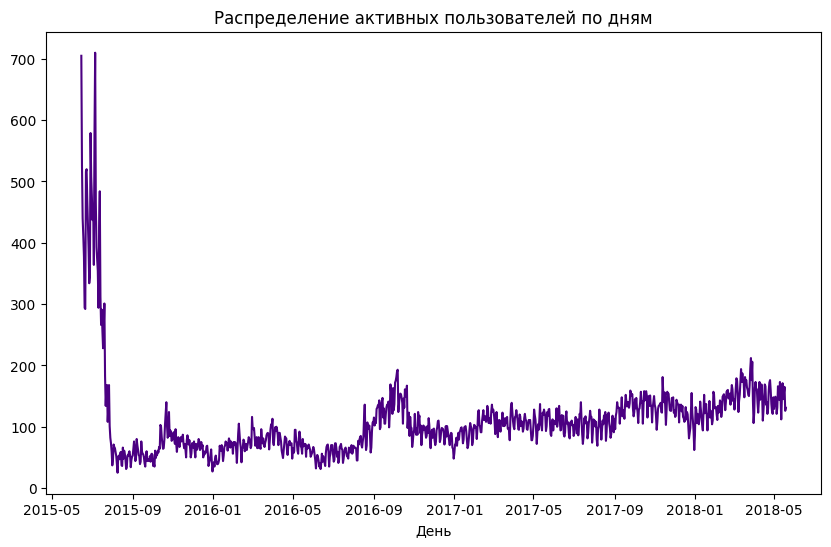

In [ ]:
event_data.groupby('day').user_id.nunique().plot(figsize=(10,6), color='indigo')
plt.title('Распределение активных пользователей по дням')
plt.xlabel('День')
plt.show()

Видим пик активности в начале. Курс был с дедлайнами, поэтом количество записавшихся было много, чтобы успеть пройти курс. Далее наблюдается спад активности.

In [ ]:
pivot_steps = event_data.pivot_table(index='user_id', 
                       columns='action', 
                       values='step_id', 
                       aggfunc='count', 
                       fill_value=0).reset_index()
pivot_steps.head()                       

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


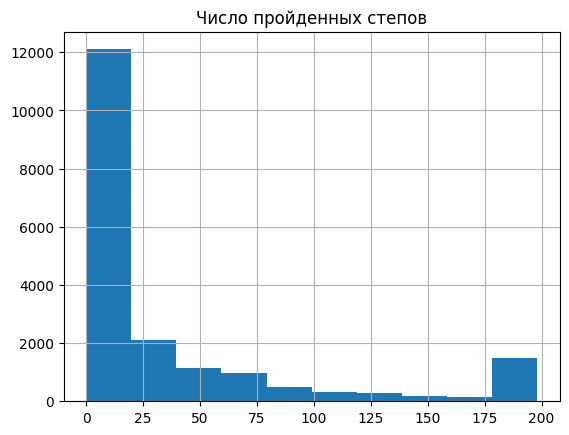

In [ ]:
pivot_steps.discovered.hist()
plt.title('Число пройденных степов')
plt.show()

Посмотрим для каждого пользователя сколько было правильных и не правильных ответов.

In [ ]:
user_scores = sub_data.pivot_table(index='user_id', columns='submission_status',
                                   values='step_id',
                                   aggfunc='count',
                                   fill_value=0).reset_index()

In [ ]:
user_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


### Разметка данных

Посмотрим какие есть промежутки между днями, когда человек проходил курс.  
Человек мог несколько раз за день заходить, поэтому оставим только одну строчку в день когда он заходил.

In [ ]:
gap_data = event_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff)

gap_data.head()    

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

Получили уникальные дни, когда человек проходил курс и посчитали разницу между этими днями.

In [ ]:
gap_data = pd.Series(np.concatenate(gap_data.values, axis=0))

In [ ]:
gap_day = gap_data / (24 * 60 * 60) # Разница в днях между заходами на курс

<Axes: >

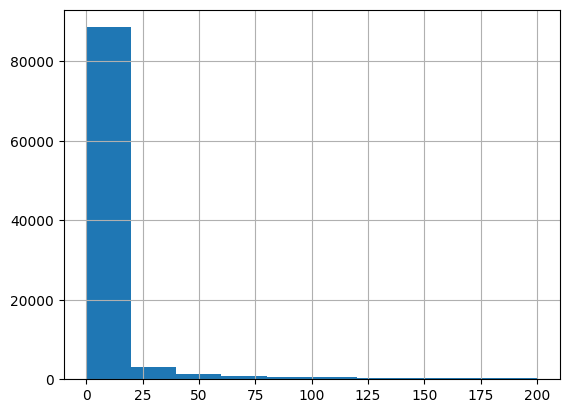

In [ ]:
gap_day[gap_day < 200].hist()

In [ ]:
gap_day.quantile(0.95), gap_day.quantile(0.90)

(59.760440972222156, 18.325995370370403)

То есть только 5% пользователей возвращаются на курс после перерыва 59 дней и 10% после перерыва 18 дней.

Возьмем перерыв равным 30 дней, который мы будем считать достаточным, для того, чтобы отнести нашего пользователя к покинувшим курс.

In [ ]:
event_data.loc[event_data['action'] == 'viewed', 'step_id'].value_counts()

32927     39845
32950     36543
32815     27613
32953     27304
32031     24726
          ...  
34049      3107
34052      3067
33913      2987
33914      2900
109765     1888
Name: step_id, Length: 198, dtype: int64

**Итак,** если человек не прошел курс до конца и не заходит в него более 30 дней, то будем считать, что он покинул курс.

In [ ]:
drop_out_threshold = 30 * 24 * 60 * 60
print(f'Пороговое значение, после которого считаем что человек покинул курс: {drop_out_threshold}')

Пороговое значение, после которого считаем что человек покинул курс: 2592000


Посчитаем максимальный `timestamp` каждого пользователя. 

In [ ]:
users_data = event_data.groupby('user_id', as_index=False) \
    .agg({'timestamp':'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [ ]:
now = event_data['timestamp'].max()
print(f'Последняя дата в наших данных: {now}')

Последняя дата в наших данных: 1526772811


In [ ]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [ ]:
users_data.head()

,user_id,last_timestamp,is_gone_usser,is_gone_user
0,1,1472827464,True,True
1,2,1519226966,True,True
2,3,1444581588,True,True
3,5,1499859939,True,True
4,7,1521634660,True,True


Объединим таблицы.

In [ ]:
user_data = users_data.merge(user_scores, on='user_id', how='outer')
user_data.head()

,user_id,last_timestamp,is_gone_usser,is_gone_user,correct,wrong
0,1,1472827464,True,True,NaN,NaN
1,2,1519226966,True,True,2.0,0.0
2,3,1444581588,True,True,29.0,23.0
3,5,1499859939,True,True,2.0,2.0
4,7,1521634660,True,True,NaN,NaN


In [ ]:
user_data = user_data.fillna(0)
user_data.head()

,user_id,last_timestamp,is_gone_usser,is_gone_user,correct,wrong
0,1,1472827464,True,True,0.0,0.0
1,2,1519226966,True,True,2.0,0.0
2,3,1444581588,True,True,29.0,23.0
3,5,1499859939,True,True,2.0,2.0
4,7,1521634660,True,True,0.0,0.0


In [ ]:
user_data = user_data.merge(pivot_steps, how='outer')

Посмотрим сколько дней пользователь был на степике.

In [ ]:
user_days = event_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [ ]:
user_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [ ]:
user_data = user_data.merge(user_days, how='outer')

In [ ]:
user_data.head()

,user_id,last_timestamp,is_gone_usser,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,True,0.0,0.0,1,1,0,1,1


Добавим колонку, где укажем дошел пользователь до конца курса или нет(будем считать, что если прошел более 170 шагов - прошел).

In [ ]:
user_data['passed_corse'] = user_data.passed > 170

In [ ]:
user_data.head()

,user_id,last_timestamp,is_gone_usser,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse
0,1,1472827464,True,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,True,0.0,0.0,1,1,0,1,1,False


Проверим, что количество пользователей совпадает и мы никого не потеряли.

In [ ]:
user_data.user_id.nunique()

19234

In [ ]:
event_data.user_id.nunique()

19234

In [ ]:
user_data.groupby('passed_corse').count()

,user_id,last_timestamp,is_gone_usser,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_corse,,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [ ]:
print(f'Процент дошедших до конца пользователей: {round(100 * 1425 / 17809, 2)}%')

Процент дошедших до конца пользователей: 8.0%


Медианное значение дней для пользователей, которые закончили курс.

In [ ]:
user_data.loc[user_data['passed_corse']].day.median()

20.0

<Axes: >

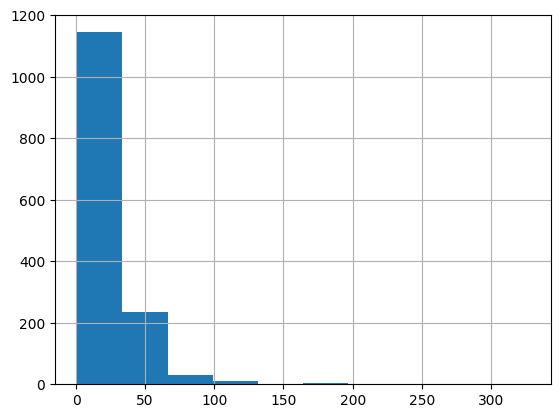

In [ ]:
user_data.loc[user_data['passed_corse']].day.hist()

Возьмем для прогноза первые три дня.

Когда пользователь сделал первое активное действие.

In [ ]:
user_min_time = event_data.groupby('user_id', as_index=False)\
    .agg({'timestamp':'min'})\
    .rename({'timestamp':'min_timestamp'}, axis=1)

In [ ]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


Добавим в нашу таблицу информацию о том, когда пользователь впервые совершил активное действие.

In [ ]:
user_data = user_data.merge(user_min_time, how='outer')

Отфильтруем датасет, чтобы в нем была информация только о первых трех днях пользователя.

In [ ]:
event_data['user_time'] = event_data.user_id.map(str) + '_' + event_data.timestamp.map(str)
event_data

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
...,...,...,...,...,...,...,...,...
3480698,32814,1526762783,discovered,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480699,32814,1526762783,passed,943,2018-05-19 20:46:23,2018-05-19,943_1526762783,943_1527021864
3480700,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950
3480701,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19,5198_1526772750,5198_1527031950


In [ ]:
learning_time_threshold = 3 * 24 * 60 * 60

In [ ]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

Для каждого пользователя проставлено его максимальное значение времени и сам id пользователя.

In [ ]:
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [ ]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [ ]:
event_data = event_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [ ]:
event_data.shape

(3480703, 8)

In [ ]:
event_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [ ]:
event_data_train = event_data[event_data.user_time <= event_data.user_learning_time_threshold]

Для каждого пользователя отобрали только те события, которые вписываютсся в промежуток от начала его прохождения курса до трех дней.

In [ ]:
event_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


Проверим себя, действительно ли мы отобрали нужные строки.

In [ ]:
event_data_train.groupby('user_id').day.nunique().max()

4

Такое может быть, если пользователь начал днем и трое суток зацепит еще один день. Но больше 4 не может быть.

Сделаем аналогично для sub_data.

In [ ]:
sub_data['user_time'] = sub_data.user_id.map(str) + '_'+ sub_data.timestamp.map(str)
sub_data = sub_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
sub_data_train = sub_data[sub_data.user_time <= sub_data.user_learning_time_threshold]
sub_data_train.groupby('user_id').day.nunique().max()

4

### Соберем таблицу для обучения

In [ ]:
X = sub_data_train.groupby('user_id').day.nunique().to_frame().reset_index()\
    .rename(columns={'day': 'days'})

In [ ]:
steps_tried = sub_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
    .rename(columns={'step_id': 'steps_tried'})

In [ ]:
X = X.merge(steps_tried, on='user_id', how='outer')
X

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23
...,...,...,...
8908,26787,1,3
8909,26790,1,1
8910,26794,3,27
8911,26797,1,2


Добавим сколько было правильных/неправильных попыток.

In [ ]:
X = X.merge(sub_data_train.pivot_table(index='user_id', columns='submission_status',
                                   values='step_id',
                                   aggfunc='count',
                                   fill_value=0).reset_index())

Добавим долю правильных ответов.

In [ ]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [ ]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


Отберем из `event_data_train` сколько было просмотрено степов.

In [ ]:
X = X.merge(event_data_train.pivot_table(index='user_id',
                                         columns='action',
                                         values='step_id',
                                         aggfunc='count',
                                         fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [ ]:
X.shape

(19234, 7)

In [ ]:
X = X.fillna(0)

In [ ]:
user_data

,user_id,last_timestamp,is_gone_usser,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp
0,1,1472827464,True,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,True,0.0,0.0,1,1,0,1,1,False,1521634660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,26790,1517495987,True,True,1.0,0.0,8,8,1,9,4,False,1451484016
19230,26793,1510225034,True,True,0.0,0.0,1,0,1,1,1,False,1510225031
19231,26794,1512035039,True,True,33.0,9.0,69,69,34,180,9,False,1495287049
19232,26797,1509995096,True,True,2.0,0.0,10,10,2,13,2,False,1508425316


In [ ]:
X = X.merge(user_data[['user_id', 'passed_corse', 'is_gone_user']], how='outer')

Отберем нужные данные, то есть те, кто еще проходит курс(не закончили и не бросили) нам не нужны.

In [ ]:
X = X[~((X.is_gone_user == False) & (X.passed_corse == False))]

In [ ]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_corse,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [ ]:
X.groupby(['passed_corse', 'is_gone_user']).user_id.count()

passed_corse  is_gone_user
False         True            16560
True          False             141
              True             1284
Name: user_id, dtype: int64

Получили для всех тех, кто не прошел курс(`passed_corse = False`), помечены как ушедшие(`is_gone_user = True`). А те, кто курс прошли, могут быть как дропнутые, так и нет.

Теперь поделим  на признаки и целевую переменную.

In [ ]:
y = X.passed_corse.map(int)

AttributeError: ignored

In [ ]:
X = X.drop(['passed_corse', 'is_gone_user'], axis=1)

Для обучение модели колонка с пользовательским id не нужна, мы переведем ее в индекс.

In [ ]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
